In [17]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import time
import math
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from flt3_data_loading import km_normed_1, flt3_filtered

In [4]:
# Oversampling
# 132 positive, 320 negative => 320 positive, 320 negative
rand.seed(0)
positive_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
new_positives = pd.DataFrame([[0.0 for j in range(km_normed_1.shape[1])] for i in range(320)])
new_positives.columns = km_normed_1.columns
for i in range(320):
    r = rand.randrange(0, len(positive_indices))
    new_positives.iloc[i] = km_normed_1.iloc[r]
    
# Combine with negative examples then shuffle
negatives = km_normed_1[np.array(flt3_filtered) == 0].set_index(new_positives.index.values)
over_combined = pd.concat([new_positives, negatives]).set_index(np.array(range(640)))
over_combined['label'] = np.array([1 for i in range(320)] + [0 for i in range(320)])
over_combined = over_combined.sample(frac=1, random_state=0).reset_index(drop=True)
oc_flt3 = over_combined.label
over_combined = over_combined.drop(['label'], axis=1)

In [5]:
# Data loading
num_workers = 0
batch_size = 64
valid_size = 0.2

data = []
for i in range(len(over_combined)):
    data.append([np.array(over_combined.iloc[i], dtype='f'), oc_flt3[i]])

num_train = len(over_combined)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [8]:
# 3 hidden layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [ ]:
%pdb

In [9]:
%%time
n_epochs = 1000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final.pt')

Epoch: 999	Train: 0.3774337135255337	Val: 0.8975575864315033	Min Val: 0.63544458150863655CPU times: user 14min 57s, sys: 42min 10s, total: 57min 7s
Wall time: 44.4 s


In [13]:
# Final model
model.load_state_dict(torch.load('model_files/model_final.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    print(pred)
    print(target)
print(score/(valid_size*10))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1])
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1])
0.6021799435441488


In [14]:
# Saved best model
model.load_state_dict(torch.load('model_files/model.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    print(pred)
    print(target)
print(score/(valid_size*10))

tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1])
0.7033235581622679


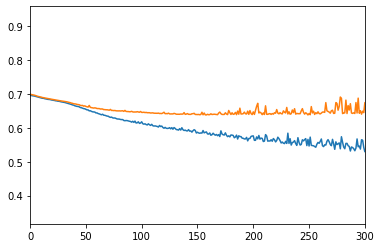

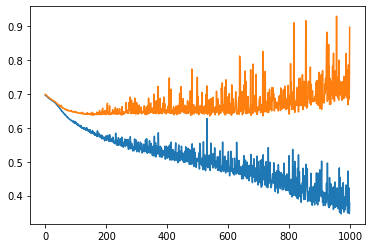

In [15]:
# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.xlim(0, 300)
plt.show()

plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 999	Train: 0.35873106867074966	Val: 0.7476687133312225	Min Val: 0.6342976689338684tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1])
tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1])
0.6394980558501238
tensor([1, 0, 0, 1, 1, 0

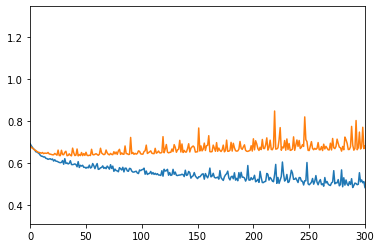

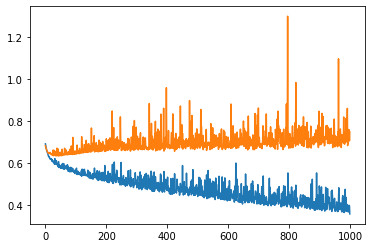

In [17]:
%%time
# 1 hidden layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 1000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print(score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print(score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.xlim(0, 300)
plt.show()

plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 9999	Train: 0.26895168237388134	Val: 0.9317548274993896	Min Val: 0.62432986497879030.7882238534412447
0.671875


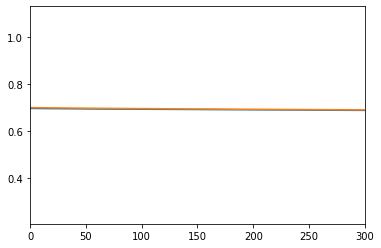

CPU times: user 2h 47min 11s, sys: 8h 20min 37s, total: 11h 7min 48s
Wall time: 8min 31s


In [20]:
%%time
# 3 hidden layers with lr=0.001
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 10000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

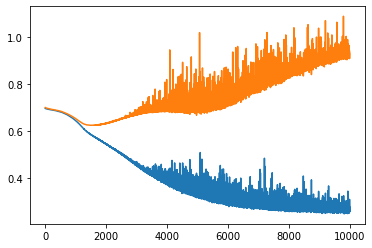

In [25]:
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 9999	Train: 0.2442981991916895	Val: 2.1148744225502014	Min Val: 0.57904255390167244
 0.7913875598086124

 0.7152625152625153


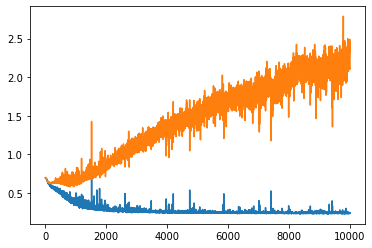

CPU times: user 2h 19min 3s, sys: 6h 50min 59s, total: 9h 10min 2s
Wall time: 7min 32s


In [26]:
%%time
# 3 layers lr=0.01 and dropout=0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 1000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 9999	Train: 0.27796196565032005	Val: 0.7877962291240692	Min Val: 0.5745876133441925
 0.7528948346339651

 0.7203902250555394


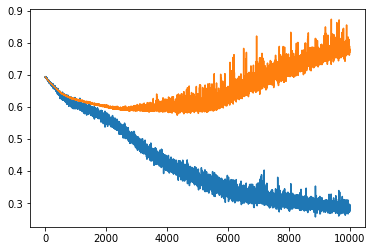

CPU times: user 2h 34min 51s, sys: 7h 13min 14s, total: 9h 48min 6s
Wall time: 7min 29s


In [8]:
%%time
# 3 layers lr=0.001 and dropout=0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 10000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_2.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_2.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_2.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_2.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 9999	Train: 0.2820390406996012	Val: 0.7855057716369629	Min Val: 0.59086862206459055
 0.7561005661005662

 0.7014705882352941


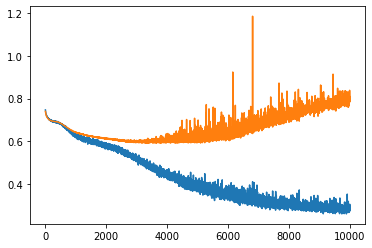

CPU times: user 3h 26min 43s, sys: 12h 8min 17s, total: 15h 35min 1s
Wall time: 19min 47s


In [10]:
%%time
# 3 layers lr=0.001 and dropout=0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 10000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_4.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_4.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_4.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_4.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 9999	Train: 0.24497009068727493	Val: 1.6497598886489868	Min Val: 0.5448181927204132
 0.7464145531400966

 0.647875457875458


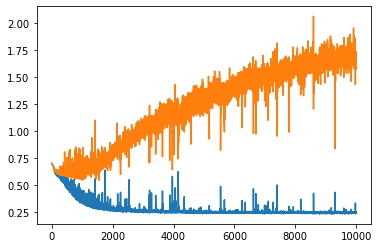

CPU times: user 2h 25min 55s, sys: 6h 48min 54s, total: 9h 14min 49s
Wall time: 7min 4s


In [11]:
%%time
# 3 layers lr=0.01 and dropout=0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 10000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_7.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_7.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_7.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_7.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 9999	Train: 0.6941030248999596	Val: 0.6916949450969696	Min Val: 0.6916732192039494
 0.5153318903318903

 0.510395622895623


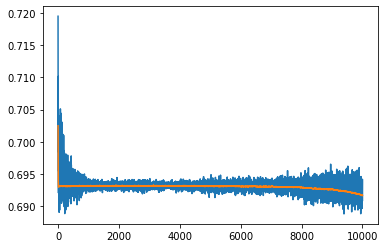

CPU times: user 8h 10min 57s, sys: 1d 4h 1min 44s, total: 1d 12h 12min 42s
Wall time: 1h 19min 59s


In [16]:
%%time
# 3 layers sigmoid lr=0.01 and dropout=0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 10000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_8.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_8.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_8.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_8.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

In [ ]:
# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

In [18]:
%%time
# sgd 5 layers sigmoid lr=0.01 and dropout=0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 5000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_11.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_11.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_11.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_11.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 2185	Train: 0.6931673809885979	Val: 0.6932434439659119	Min Val: 0.6931335330009468

KeyboardInterrupt: 

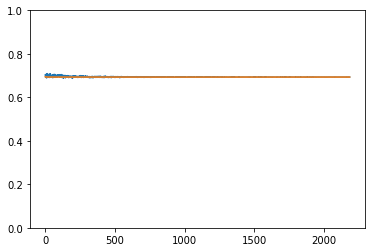

In [19]:
# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()